# **Sentiment Analysis** of the **Restaurant Reviews** from **YELP** Dataset


## **BERT**

### The two datasets (**review** and **business**) that we need from **YELP** dataset can be found <a href="https://www.yelp.com/dataset" target="_blank">here</a>

#### Install the **Transformers** library

In [1]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 4.6 MB/s 
     |████████████████████████████████| 596 kB 33.6 MB/s 
     |████████████████████████████████| 6.6 MB 36.5 MB/s 
     |████████████████████████████████| 880 kB 30.7 MB/s 
     |████████████████████████████████| 77 kB 5.9 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=5c0f4ef5ef0211e412eee70054f3e4cdb6734890003cc902f5f95ad975968cf6
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


#### Importing most of the libraries 

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import rc
from pylab import rcParams
import matplotlib.pyplot as plt
from textwrap import wrap
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,f1_score,precision_score, recall_score

import re
import spacy
sp = spacy.load('en_core_web_sm')

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

import transformers
from transformers import BertModel, BertTokenizer, BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup

import torch
from torch import nn,optim
from torch.utils.data import Dataset,DataLoader,TensorDataset, RandomSampler, SequentialSampler
import torch.nn as nn  
import torch.nn.functional as F  
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

import time 
import datetime

import tensorflow as tf

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid',palette='muted',font_scale=1.2)
color_palette=['#01BEFE','#FFDD00','#FF7D00','#FF006D','#ADFF02','#8F00FF']
sns.set_palette(sns.color_palette(color_palette))

rcParams['figure.figsize']= 10,5

seed=42
np.random.seed(seed)
torch.manual_seed(seed)

import sys
import os
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


#### **Read** the **reviews** dataset. As it is a **very heavy** one, let's use only the first 10,000 rows and **reduce** the **memory usage**

In [4]:
df = pd.read_json('/content/drive/MyDrive/yelp_academic_dataset_review.json', nrows=10000, lines=True)

In [5]:
df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,lWC-xP3rd6obsecCYsGZRg,ak0TdVmGKo4pwqdJSTLwWw,buF9druCkbuXLX526sGELQ,4,3,1,1,Apparently Prides Osteria had a rough summer a...,2014-10-11 03:34:02
1,8bFej1QE5LXp4O05qjGqXA,YoVfDbnISlW0f7abNQACIg,RA4V8pr014UyUbDvI-LW2A,4,1,0,0,This store is pretty good. Not as great as Wal...,2015-07-03 20:38:25
2,NDhkzczKjLshODbqDoNLSg,eC5evKn1TWDyHCyQAwguUw,_sS2LBIGNT5NQb6PD1Vtjw,5,0,0,0,I called WVM on the recommendation of a couple...,2013-05-28 20:38:06
3,T5fAqjjFooT4V0OeZyuk1w,SFQ1jcnGguO0LYWnbbftAA,0AzLzHfOJgL7ROwhdww2ew,2,1,1,1,I've stayed at many Marriott and Renaissance M...,2010-01-08 02:29:15
4,sjm_uUcQVxab_EeLCqsYLg,0kA0PAJ8QFMeveQWHFqz2A,8zehGz9jnxPqXtOc7KaJxA,4,0,0,0,The food is always great here. The service fro...,2011-07-28 18:05:01


#### **Drop the columns** that we **won't be needing**

In [6]:
cols_to_drop = ['review_id', 'user_id', 'useful', 'funny', 'cool', 'date'] 
df.drop(cols_to_drop, axis=1, inplace=True)

In [7]:
df.head()

,business_id,stars,text
0,buF9druCkbuXLX526sGELQ,4,Apparently Prides Osteria had a rough summer a...
1,RA4V8pr014UyUbDvI-LW2A,4,This store is pretty good. Not as great as Wal...
2,_sS2LBIGNT5NQb6PD1Vtjw,5,I called WVM on the recommendation of a couple...
3,0AzLzHfOJgL7ROwhdww2ew,2,I've stayed at many Marriott and Renaissance M...
4,8zehGz9jnxPqXtOc7KaJxA,4,The food is always great here. The service fro...


#### **Importing** the **business** dataset

In [8]:
df1 = pd.read_json('/content/drive/MyDrive/yelp_academic_dataset_business.json', lines=True)

In [9]:
df1.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,6iYb2HFDywm3zjuRg0shjw,Oskar Blues Taproom,921 Pearl St,Boulder,CO,80302,40.017544,-105.283348,4.0,86,1,"{'RestaurantsTableService': 'True', 'WiFi': 'u...","Gastropubs, Food, Beer Gardens, Restaurants, B...","{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'..."
1,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,126,1,"{'RestaurantsTakeOut': 'True', 'RestaurantsAtt...","Salad, Soup, Sandwiches, Delis, Restaurants, C...","{'Monday': '5:0-18:0', 'Tuesday': '5:0-17:0', ..."
2,bvN78flM8NLprQ1a1y5dRg,The Reclaimory,4720 Hawthorne Ave,Portland,OR,97214,45.511907,-122.613693,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Antiques, Fashion, Used, Vintage & Consignment...","{'Thursday': '11:0-18:0', 'Friday': '11:0-18:0..."
3,oaepsyvc0J17qwi8cfrOWg,Great Clips,2566 Enterprise Rd,Orange City,FL,32763,28.914482,-81.295979,3.0,8,1,"{'RestaurantsPriceRange2': '1', 'BusinessAccep...","Beauty & Spas, Hair Salons",None
4,PE9uqAjdw0E4-8mjGl3wVA,Crossfit Terminus,1046 Memorial Dr SE,Atlanta,GA,30316,33.747027,-84.353424,4.0,14,1,"{'GoodForKids': 'False', 'BusinessParking': '{...","Gyms, Active Life, Interval Training Gyms, Fit...","{'Monday': '16:0-19:0', 'Tuesday': '16:0-19:0'..."


#### We **only** want to analyze the **restaurant** category from the **business** dataset

In [10]:
df1 = df1[df1['categories'].notnull()]
df_rest = df1[df1['categories'].str.contains('Restaurant')]

In [11]:
df_rest = df_rest[['business_id', 'categories']]

In [12]:
df_rest.head()

,business_id,categories
0,6iYb2HFDywm3zjuRg0shjw,"Gastropubs, Food, Beer Gardens, Restaurants, B..."
1,tCbdrRPZA0oiIYSmHG3J0w,"Salad, Soup, Sandwiches, Delis, Restaurants, C..."
5,D4JtQNTI4X3KcbzacDJsMw,"Restaurants, Thai"
7,jFYIsSb7r1QeESVUnXPHBw,"Breakfast & Brunch, Restaurants"
12,HPA_qyMEddpAEtFof02ixg,"Food, Pizza, Restaurants"


#### We want to **merge** the two datasets to analyse the **restaurant reviews**. "**business_id**" is the **common** columm of the two datasets

In [13]:
# business_id is tne common columm of the two datasets
df_merged = df.merge(df_rest, how='inner', on='business_id')

In [14]:
del df, df_rest

In [15]:
df_merged.head()

,business_id,stars,text,categories
0,buF9druCkbuXLX526sGELQ,4,Apparently Prides Osteria had a rough summer a...,"Restaurants, Wine Bars, Nightlife, Farmers Mar..."
1,buF9druCkbuXLX526sGELQ,2,I was really disappointed to say the least. I ...,"Restaurants, Wine Bars, Nightlife, Farmers Mar..."
2,buF9druCkbuXLX526sGELQ,5,This is as close to dining in Italy as you'll ...,"Restaurants, Wine Bars, Nightlife, Farmers Mar..."
3,buF9druCkbuXLX526sGELQ,5,Great food and service! Again. 4 out of the la...,"Restaurants, Wine Bars, Nightlife, Farmers Mar..."
4,0AzLzHfOJgL7ROwhdww2ew,2,I've stayed at many Marriott and Renaissance M...,"Hotels, Hotels & Travel, Restaurants, Event Pl..."


#### **Rename** the **text column** and **remove** the **"business_id"** column because it **isn't necessary anymore**

In [16]:
# Rename the text column and remove the "business_id" column because it isn't necessary anymore
df_merged.rename(columns={'text':'restaurant_reviews'}, inplace=True)
df_merged.drop('business_id', axis=1, inplace=True)

#### We will **only** analyse the reviews **written** in **English**

In [17]:
!pip install langdetect

     |████████████████████████████████| 981 kB 5.3 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=51e9f3b3407903ad4967ee6eec09586506b8b6b12914739209fd2f37d233a4a7
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect


In [18]:
from langdetect import detect

In [19]:
df_merged['detect'] = df_merged['restaurant_reviews'].apply(detect)
df_merged = df_merged[df_merged['detect'] == 'en'].reset_index(drop=True)

In [20]:
# Check if there is NaN values
df_merged.isnull().values.any()

False

In [21]:
df_merged.shape

(6987, 4)

#### Return the dataframe with **duplicate** rows **removed**

In [22]:
df_final = df_merged.drop_duplicates()

#### As **many** of the **3 stars reviews**, most likely, have both **good and bad aspects/feelings**, we will **remove** those reviews so they **won't harm** our sentiment analysis

In [23]:
df_final = df_final[(df_final["stars"]!=3)]
df_final.head(20)

,stars,restaurant_reviews,categories,detect
0,4,Apparently Prides Osteria had a rough summer a...,"Restaurants, Wine Bars, Nightlife, Farmers Mar...",en
1,2,I was really disappointed to say the least. I ...,"Restaurants, Wine Bars, Nightlife, Farmers Mar...",en
2,5,This is as close to dining in Italy as you'll ...,"Restaurants, Wine Bars, Nightlife, Farmers Mar...",en
3,5,Great food and service! Again. 4 out of the la...,"Restaurants, Wine Bars, Nightlife, Farmers Mar...",en
4,2,I've stayed at many Marriott and Renaissance M...,"Hotels, Hotels & Travel, Restaurants, Event Pl...",en
5,4,I was a there for a professional conference. s...,"Hotels, Hotels & Travel, Restaurants, Event Pl...",en
6,4,I stayed for five nights this past April with ...,"Hotels, Hotels & Travel, Restaurants, Event Pl...",en
7,4,I stayed here recently for a conference I was ...,"Hotels, Hotels & Travel, Restaurants, Event Pl...",en
8,4,The food is always great here. The service fro...,"Restaurants, French",en
9,2,Brasserie zero zero... we were hoping for a te...,"Restaurants, French",en


#### **Label** reviews as **positive** - **1** (4 and 5 stars) - or **negative** - **0** (1 and 2 stars) - and after that **remove** the **"stars" column**, it is not needed anymore

In [24]:
# label reviews as positive or negative and after that remove the "stars" column, it is not needed anymore
 
df_final.loc[df_final['stars'] < 3, 'sentiment'] = 0 
df_final.loc[df_final['stars'] > 3, 'sentiment'] = 1
df_final.drop('stars', axis=1, inplace=True)
df_final.head(10)

,restaurant_reviews,categories,detect,sentiment
0,Apparently Prides Osteria had a rough summer a...,"Restaurants, Wine Bars, Nightlife, Farmers Mar...",en,1.0
1,I was really disappointed to say the least. I ...,"Restaurants, Wine Bars, Nightlife, Farmers Mar...",en,0.0
2,This is as close to dining in Italy as you'll ...,"Restaurants, Wine Bars, Nightlife, Farmers Mar...",en,1.0
3,Great food and service! Again. 4 out of the la...,"Restaurants, Wine Bars, Nightlife, Farmers Mar...",en,1.0
4,I've stayed at many Marriott and Renaissance M...,"Hotels, Hotels & Travel, Restaurants, Event Pl...",en,0.0
5,I was a there for a professional conference. s...,"Hotels, Hotels & Travel, Restaurants, Event Pl...",en,1.0
6,I stayed for five nights this past April with ...,"Hotels, Hotels & Travel, Restaurants, Event Pl...",en,1.0
7,I stayed here recently for a conference I was ...,"Hotels, Hotels & Travel, Restaurants, Event Pl...",en,1.0
8,The food is always great here. The service fro...,"Restaurants, French",en,1.0
9,Brasserie zero zero... we were hoping for a te...,"Restaurants, French",en,0.0


#### Let's see if the dataset is **balanced or not**: **it isn't...**

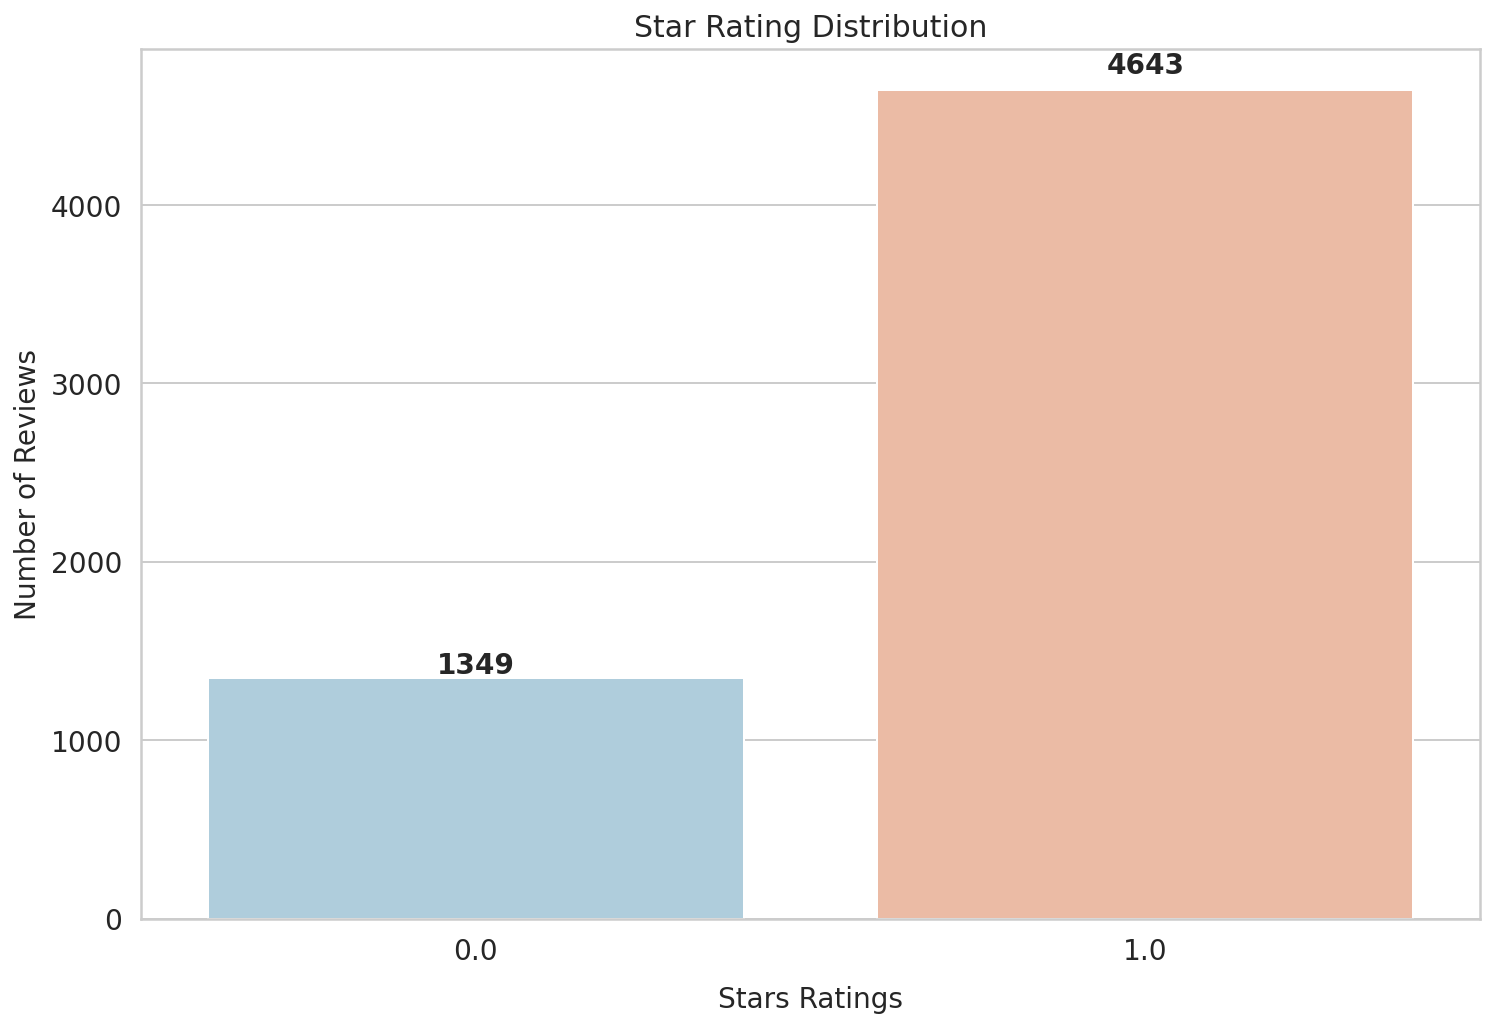

In [25]:
warnings.simplefilter(action='ignore', category=FutureWarning)
# See if the dataset is balanced or not: its isn't...
plt.figure(figsize=(12,8))
grouped = df_final.sentiment.value_counts().sort_index()
sns.barplot(grouped.index, grouped.values, palette=sns.color_palette("RdBu_r", len(grouped)))
plt.xlabel('Stars Ratings', labelpad=10, fontsize=14)
plt.ylabel('Number of Reviews', fontsize=14)
plt.title('Star Rating Distribution', fontsize=15)
plt.tick_params(labelsize=14)
for  i, v in enumerate(grouped):
    plt.text(i, v*1.02, str(v), horizontalalignment ='center',fontweight='bold', fontsize=14)

#### As the dataset is **imbalanced** we **upsample** the **minority class** (negative sentiment - 0):

In [26]:
from sklearn.utils import resample

#create two different dataframes: one regarding the majority and the other the minority class 
df_majority = df_final[(df_final['sentiment']==1)] 
df_minority = df_final[(df_final['sentiment']==0)] 


df_minority_upsampled = resample(df_minority, 
                                 replace=True,   
                                 n_samples= 4643, # to match majority class
                                 random_state=42)  
# Combine majority class with upsampled minority class
df_final = pd.concat([df_minority_upsampled, df_majority])

In [27]:
df_final.sentiment.value_counts()

0.0    4643
1.0    4643
Name: sentiment, dtype: int64

#### **Stopwords** with **spaCy**. As **'no'** and **'not'** are **important** words to describe an opinion about a restaurant (e.g. not cheap, not a good service, no napkins available, etc.), we should, at least, **remove** those two words from the **stopwords**. 

- **Note**: using stopwords provides **context**, so when using a **contextual model** like **BERT** one **should usually keep** them to **provide** enough **context information**; however, in this case, when spliting the dataset into train, validation and test sets, we can see that for two of those three sets the **number of tokens** in some reviews (in one of the sets **more than 600** and in the other **more than 700**) **exceeds the maximum length possible** (512), being so we decided to **exclude the stopwords** with the **exception of the two words already mentioned**.

In [28]:
sp = spacy.load('en_core_web_sm')
stopwords = sp.Defaults.stop_words

exclude_stopwords = ['no','not']
for word in exclude_stopwords:
    stopwords.remove(word)

#### **UDF** to **remove non-letters**, convert to **lower case**, **tokenize** with **NLTK** and **remove** the **spaCy stopwords** from the restaurant reviews:

In [29]:
# The input is a single string (a raw restaurant review), and the output is a single string (a preprocessed restaurant review)

def text_preprocessing( raw_review ):
    # 1. Remove non-letters 
    review_text_letters_only = re.sub("[^a-zA-Z]", " ", raw_review)
    # 2. Convert to lower case
    review_preprocessed = review_text_letters_only.lower()
    # 3. Word tokenization
    review_tokens = word_tokenize(review_preprocessed)
    # 4. Filter the stopwords
    filtered_sentence =[] 
    for word in review_tokens:
        lexeme = sp.vocab[word]
        if lexeme.is_stop == False:
            filtered_sentence.append(word)

    return " ".join(filtered_sentence)

#### **Apply** the above **UDF** to the **entire** 'restaurant_reviews' column, **creating** a **new column** named **'cleaned_reviews'**

In [30]:
df_final['cleaned_reviews'] = df_final['restaurant_reviews'].apply(text_preprocessing) 

In [31]:
df = df_final.reset_index(drop=True)

In [32]:
df.head()

,restaurant_reviews,categories,detect,sentiment,cleaned_reviews
0,"There were maybe 8 tables in the restaurant, ...","Bars, Restaurants, Chicken Wings, Sports Bars,...",en,0.0,maybe tables restaurant waitress busy talking ...
1,The food was good but Worst service I ever had...,"Restaurants, American (New)",en,0.0,food good worst service bad mean bad menus sil...
2,Be aware the April server charge extra tip to ...,"American (Traditional), Restaurants, Bars, Tex...",en,0.0,aware april server charge extra tip paid tip
3,This place has really gone down hill on servic...,"Restaurants, Cafes, Breakfast & Brunch",en,0.0,place gone hill service waitress food prep del...
4,"Placed order online for delivery, to be delive...","Sandwiches, Wraps, Chicken Wings, Restaurants",en,0.0,placed order online delivery delivered work br...


## **Sentiment analysis** of **YELP restaurant reviews** with **BERT** in **PyTorch**

#### Define the **pre-trained model** we are going to use: 

- “**bert-base-uncased**” is the version that has only lowercase letters (“uncased”) and is the smaller version of the two (“base” vs “large”).

In [33]:
pre_trained_model='bert-base-uncased'

#### To **feed** our **reviews** to BERT they must be **split into tokens**, and then these tokens **must be mapped to their index in the tokenizer vocabulary**.


- When we **actually convert all of our reviews**, we’ll **use** the `tokenize.encode` function to **handle both steps**, rather than calling `tokenize` and `convert_tokens_to_ids` separately

- **Load** the **BERT Tokenizer**: 

In [34]:
tokenizer=BertTokenizer.from_pretrained(pre_trained_model)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

#### Before we are ready to **encode our reviews** we need to decide on a **maximum sentence length**. BERT **expects fixed-length sequences**, let's choose **maximum sequence length**:

In [35]:
token_lens = []

for txt in df.cleaned_reviews:
  tokens = tokenizer.encode(txt, max_length=512, truncation=True)
  token_lens.append(len(tokens))

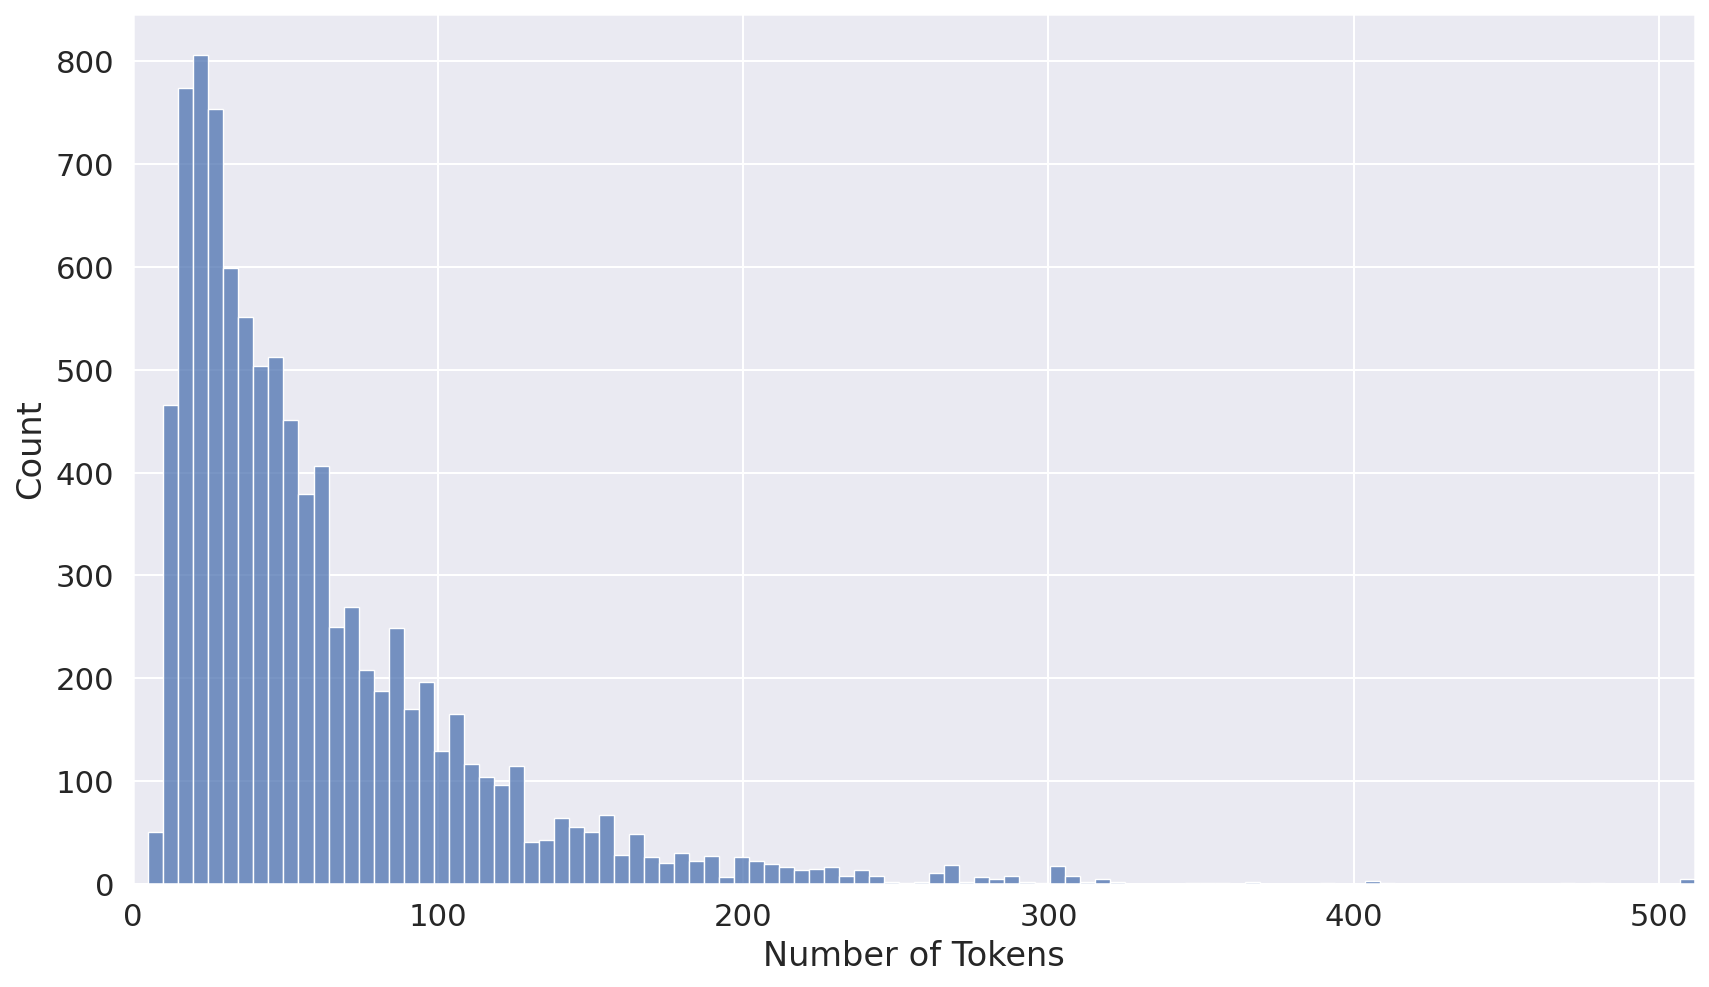

In [36]:
sns.set(font_scale=1.4)
plt.rcParams["figure.figsize"] = (14,8)
sns.histplot(token_lens)
plt.xlim([0, 512])
plt.xlabel('Number of Tokens')
plt.show()

#### The **great majority** of the reviews seems to have **less than 240 tokens**, that's the **maximum length** that we'll choose.

In [37]:
MAX_SEQ_LENGTH = 240

#### **Split** the **dataset** into **train** (70 %), **validation** (15%) and **test** (15%) sets and **preserve** the **same proportions** of **observations** in **each class** as **observed** in the **original dataset**

In [38]:
x_train, x_test, y_train, y_test = train_test_split(df['cleaned_reviews'],df.sentiment, test_size=0.3, random_state = 42, stratify=df.sentiment)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state = 42, stratify= y_test)

In [39]:
y_train = y_train.astype(int)
y_val = y_val.astype(int)
y_test = y_test.astype(int)

#### **Convert to list each of the sets**

In [40]:

train_reviews = x_train.tolist()
val_reviews = x_val.tolist()
test_reviews = x_test.tolist()

### **Create** a sequence of **token ids** (input ids) for **each review**

- **`tokenizer.encode`** converts a **string** in a sequence of **intput ids** (integers) using the **tokenizer** and the **vocabulary**, meaning, it **splits** a string **into tokens** and **map the tokens to their ids**.


-  We must **add special tokens** - `[CLS]` and `[SEP]` - for **classification** tasks.

In [41]:
# Train dataset
train_input_ids = [tokenizer.encode(train_reviews[i],add_special_tokens = True, max_length=MAX_SEQ_LENGTH, truncation=True) for i in range(0,len(train_reviews))]
# Val dataset
val_input_ids = [tokenizer.encode(val_reviews[i],add_special_tokens = True, max_length=MAX_SEQ_LENGTH, truncation=True) for i in range(0,len(val_reviews))]
# Test dataset
test_input_ids = [tokenizer.encode(test_reviews[i],add_special_tokens = True, max_length=MAX_SEQ_LENGTH, truncation=True) for i in range(0,len(test_reviews))]

### **Padding** and **truncating**: pad and truncate our sequences so that they all have the **same length**:

- **Padding**: when necessary, paddding wiil **add zeros** to make all the sequences **reach** the **length** of **MAX_SEQ_LENGTH**

- **Truncating**: when necessary, sequences **longer than the MAX_SEQ_LENGTH** are **truncated** to **MAX_SEQ_LENGTH**

- **Note**: '**post**' specifies that we want to pad and truncate at the **end** of the sequence. 

In [42]:
from keras.preprocessing.sequence import pad_sequences    # Pad utility function to pad sequences to maximum length.
 
# Padding value: is optional, the default is 0.

# Train dataset
train_input_ids = pad_sequences(train_input_ids, maxlen=MAX_SEQ_LENGTH, dtype="long", 
                          value=0, truncating="post", padding="post")

# Validation dataset
val_input_ids = pad_sequences(val_input_ids, maxlen=MAX_SEQ_LENGTH, dtype="long", 
                          value=0, truncating="post", padding="post")

# Test dataset
test_input_ids = pad_sequences(test_input_ids, maxlen=MAX_SEQ_LENGTH, dtype="long", 
                          value=0, truncating="post", padding="post")

### **Attention Masks**

The attention masks **differentiate** which tokens are **`real`** tokens versus which are **`[PAD]`** tokens.

In [43]:
# Create attention masks

# Train dataset
train_attention_masks = [[int(token_id > 0) for token_id in review]
                         for review in train_input_ids]
# dev dataset
val_attention_masks = [[int(token_id > 0) for token_id in review]
                         for review in val_input_ids]
# Test dataset
test_attention_masks = [[int(token_id > 0) for token_id in review]
                         for review in test_input_ids]

### **Convert all lists** of **inputs ids**, **labels** and **attention masks** into **torch tensors**

In [44]:
# input_ids
train_inputs = torch.tensor(train_input_ids)
val_inputs = torch.tensor(val_input_ids)
test_inputs = torch.tensor(test_input_ids)
# labels
train_labels = torch.tensor(y_train.values)
val_labels = torch.tensor(y_val.values)
test_labels = torch.tensor(y_test.values)
# attention masks
train_masks = torch.tensor(train_attention_masks)
val_masks = torch.tensor(val_attention_masks)
test_masks = torch.tensor(test_attention_masks)

### Create a **`DataLoader`** to **load** our **datasets**. Serves as an **iterator**, it **saves memory during training** when compared with a **for loop**

In [45]:
batch_size = 16

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Create the DataLoader for our test set.
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [46]:
# Number of classes / labels
n_classes = y_train.nunique()
n_classes

2

## **Build a sentiment Classifier**

### **BertForSequenceClassification**

- We'll use the **BertForSequenceClassification** model for our classification task. It's a **Bert Model transformer** with an **added layer on top of it** for **classification**.

- We are using **Pytorch framework** for model **training** and **evaluation** for **classification** purposes, hence we have chosen **BertForSequeunceClassification class** to be used.

#### **Instantiate** our model:

In [47]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # The 12-layer BERT model with an uncased vocab
    num_labels = 2, # For binary classification  
    output_attentions = False, # Not to return attentions weights
    output_hidden_states = False, # Not to return all hidden-states
)


Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

#### **Move** our model to the **GPU**

In [48]:
model = model.to(device) 

### To **fine-tune** our Bert Classifier we need to create an **`optimizer`**. The authors have some **recommendations** for **fine-tuning**:

- **Batch size**: 16, 32
- **Learning rate** (Adam): 5e-5, 3e-5, 2e-5
- **Number of epochs**: 2, 3 or 4

We chose **16**, **3e-5** and **2**, respectively.




### **Optimizer**, **learning rate scheduler**, **loss function** and **number of epochs**
- Considering the **original paper on BERT**, we will use <a href="https://huggingface.co/transformers/main_classes/optimizer_schedules.html" target="_blank">AdamW</a> **optimizer** because it implements **gradient bias correction as well as weight decay**. We will also use linear scheduler with no warm up steps.

In [49]:
epochs=2

optimizer=AdamW(model.parameters(),lr=3e-5)
total_steps=len(train_dataloader)*epochs

# Create the learning rate scheduler
scheduler=get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)
 # Define loss function and move it to GPU
loss_fn=nn.CrossEntropyLoss().to(device)

## **Training** our model. We'll take the following steps:

#### Function for calculating **elapsed time**

In [50]:
def format_time(elapsed):
    # Round to the nearest second
    elapsed_round = int(round(elapsed))
    # Format time in hh:mm:ss
    return str(datetime.timedelta(seconds = elapsed_round))

#### Function for calculating **accuracy**

In [51]:
def accuracy(preds, labels):
    preds = np.argmax(preds, axis=1).flatten()
    labels = labels.flatten()
    return np.sum(preds == labels) / len(labels)

### **Training** 
- We can **store** the **training** and **validation loss** and **accuracy values** and then **plot** or **make a table** to **measure the performance** on both the **train** and **validation** sets **after the completion of each epoch** so we can see **more clearly** the **progress** of the **training loop**.



In [52]:
# Store for each epoch
loss_train_values = []
acc_train_values = []
loss_val_values = []
acc_val_values = []
for epoch in range(0,epochs):
     
        #             --- Train---
        
        # Perform forward pass over the training dataset
        print("\n Epoch {:}/{:} :".format(epoch+1,epochs))
        print('Training....')
        
        # Measure how long the training epoch takes
        t0 = time.time()
        # Reset total loss and accuracy for this epoch
        total_loss = 0
        total_acc = 0

        # Put the model in training mode
        model.train()
        
        # For each batch of training data
        for step, batch in enumerate(train_dataloader):
            # Update progress for each 100 steps
            if (step % 100==0) & (not step==0):
                # Calculate elapsed time in minutes
                elapsed = format_time((time.time()-t0))
                # Report progress
                print(' Batch {:>5,} of {:>5,}. Elapsed:{:}.'.format(step,len(train_dataloader),elapsed))
            
            # Unpack training batch from trainloader and move to GPU
            b_input_ids = batch[0].to(device)  # 0 - input ids tensor
            b_attention_mask = batch[1].to(device) # 1 - input masks tensor
            b_labels = batch[2].to(device) # 2 - labels tensor
            
            # Clear any previously calculated gradients in Pytorch before performing a backward pass
            model.zero_grad()
            
            # Output the results
            outputs = model(input_ids = b_input_ids, attention_mask = b_attention_mask, labels=b_labels) # Return tuple
            # Loss value from output
            loss = outputs.loss   # Loss
            
            # Update total loss
            total_loss += loss.item()
            
            preds = outputs.logits  # Output probabilities
            # Move logits and labels to CPU
            preds = preds.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            # Calculate the accuracy for this batch 
            tmp_train_accuracy = accuracy(preds, label_ids)

            # Accumulate the total accuracy
            total_acc += tmp_train_accuracy
            
            # Perform a backward pass to calculate gradients
            loss.backward()
            
            # To avoid exploding vanishing gradients problem, clip the norm of the gradients to 1.0
            torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)
            
            # Update the parameters (weights)
            optimizer.step()
            
            # Update the learning rate
            scheduler.step()
            
        # Calculate the average loss over training data
        avg_total_loss = total_loss/len(train_dataloader)
            
        # Store the loss values
        loss_train_values.append(avg_total_loss)

        # Calculate the average accuracy over the training data
        avg_train_acc = total_acc / len(train_dataloader)

        # Store the accuracy values 
        acc_train_values.append(avg_train_acc)

        print("")
        print("\nAverage training accuracy: {0:.2f}".format(avg_train_acc))
        
        print('Average training loss : {0:.2f}'.format(avg_total_loss))
        print('Training epoch took: {:}'.format(format_time(time.time()- t0)))
 
        #             --- VALIDATION ---

        
        # After each epoch perform validation to check model performance
        print('\n Running validation...')
        
        t0 = time.time()
        # Put model in evaluation mode
        model.eval()
        
        # Tracking variables
        total_eval_accuracy = 0
        total_eval_loss = 0
        
        # Unpack validation batch from trainloader and move to GPU
        for batch in val_dataloader: 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            # Tell model not to compute gradients to save memory and accelerate validation
            with torch.no_grad():
                # Forward pass, calculate logit prediction
                 outputs = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            loss = outputs.loss
            logits = outputs.logits
            # Update total evaluation loss
            total_eval_loss += loss.item()
            
            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            # Calculate the accuracy for this batch and accumulate it over all batches
            total_eval_accuracy += accuracy(logits, label_ids)

        # Compute the average accuracy over all of the batches
        avg_val_accuracy = total_eval_accuracy / len(val_dataloader)

        # Store the accuracy values 
        acc_val_values.append(avg_val_accuracy)
     
        # Compute the average loss over all of the batches
        avg_val_loss = total_eval_loss / len(val_dataloader)

         # Store the loss values
        loss_val_values.append(avg_val_loss)
    
    # Measure how long the validation run took.
        validation_time = format_time(time.time() - t0)
        print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
        print("  Validation Loss: {0:.2f}".format(avg_val_loss))
        print("  Validation took: {:}".format(validation_time))




 Epoch 1/2 :
Training....
 Batch   100 of   407. Elapsed:0:02:00.
 Batch   200 of   407. Elapsed:0:04:01.
 Batch   300 of   407. Elapsed:0:06:01.
 Batch   400 of   407. Elapsed:0:08:02.


Average training accuracy: 0.90
Average training loss : 0.25
Training epoch took: 0:08:09

 Running validation...
  Accuracy: 0.95
  Validation Loss: 0.18
  Validation took: 0:00:37

 Epoch 2/2 :
Training....
 Batch   100 of   407. Elapsed:0:02:00.
 Batch   200 of   407. Elapsed:0:04:01.
 Batch   300 of   407. Elapsed:0:06:01.
 Batch   400 of   407. Elapsed:0:08:02.


Average training accuracy: 0.98
Average training loss : 0.08
Training epoch took: 0:08:09

 Running validation...
  Accuracy: 0.97
  Validation Loss: 0.14
  Validation took: 0:00:37


**Plot validation accuracy after** the **completion** of **each epoch**:

In [53]:
df_acc = pd.DataFrame(acc_val_values,columns=['Accuracy'])

In [54]:
df_acc.index+=1

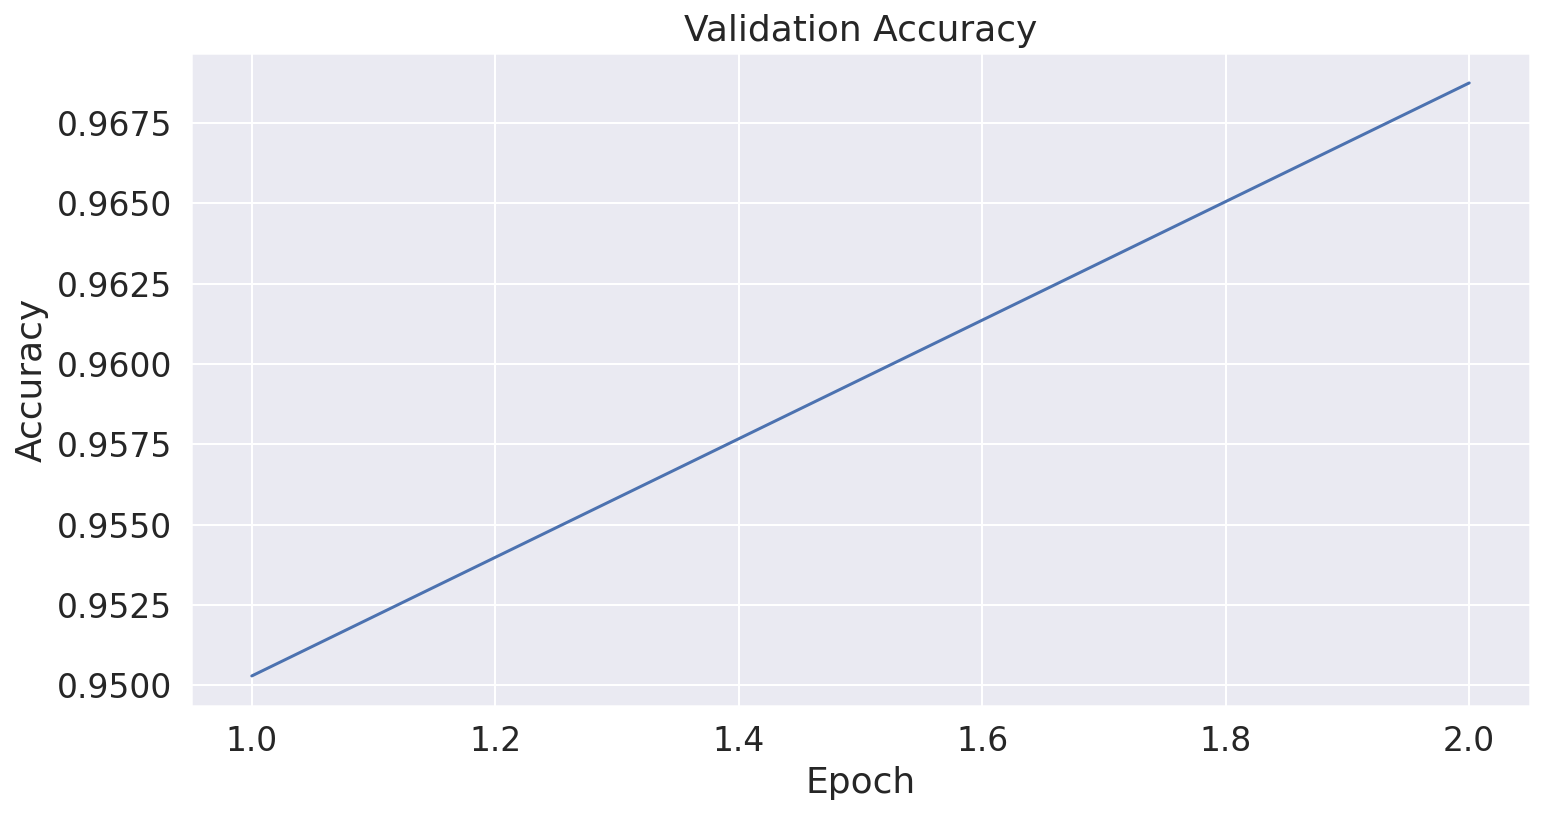

In [55]:
# Use plot styling from seaborn
sns.set(style='darkgrid')

# Increase the plot size and font size
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve
sns.lineplot(data=df_acc,x=df_acc.index,y=df_acc.Accuracy)

# Label the plot
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.show()

**Plot validation loss after** the **completion** of **each epoch**:

In [56]:
df_loss = pd.DataFrame(loss_val_values,columns=['Loss'])

In [57]:
df_loss.index+=1

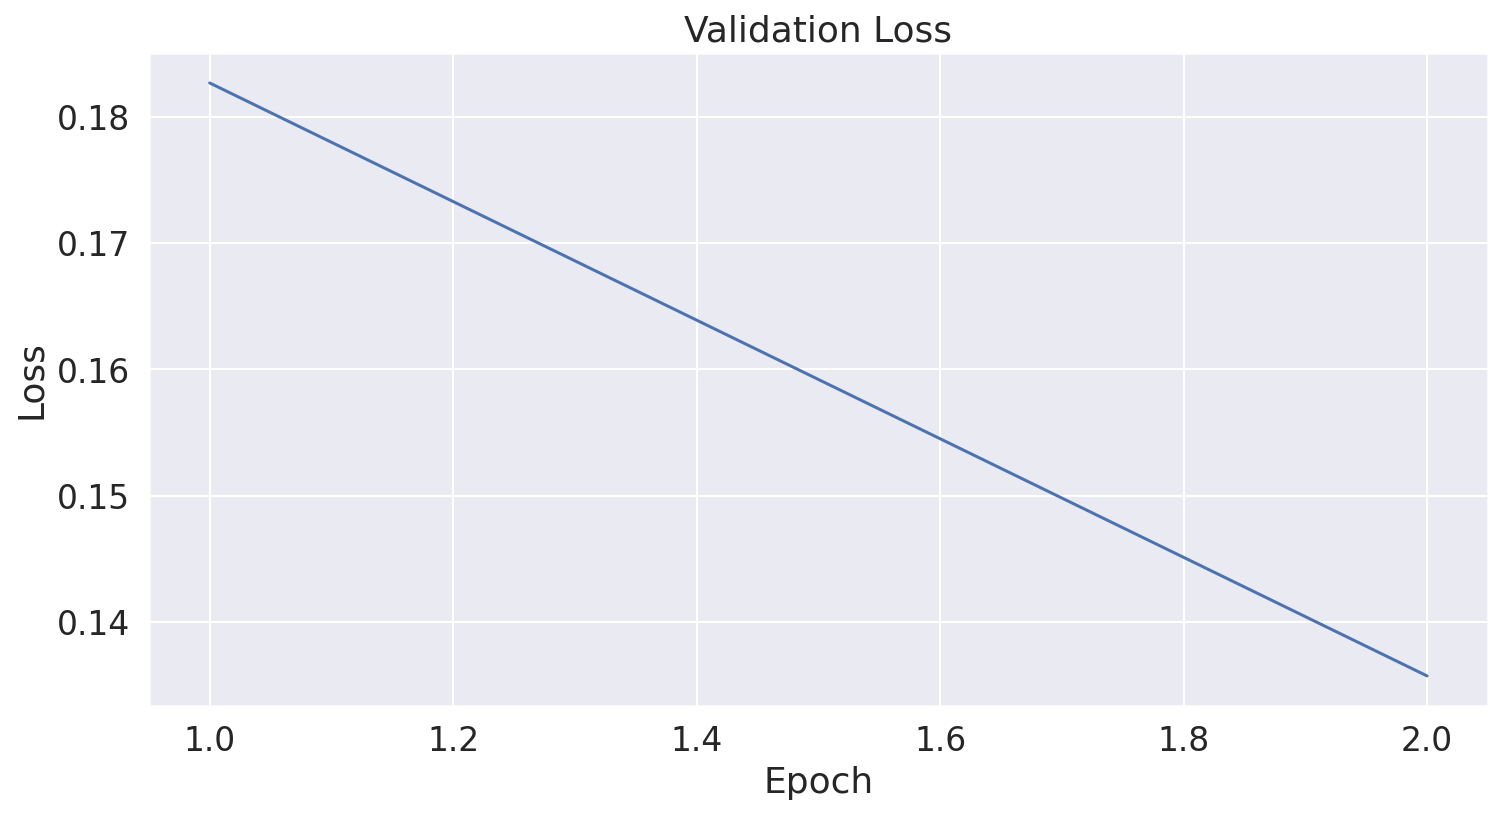

In [58]:
# Use plot styling from seaborn
sns.set(style='darkgrid')

# Increase the plot size and font size
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve
sns.lineplot(data=df_loss,x=df_loss.index,y=df_loss.Loss)

# Label the plot
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

#### **Predicting** on **test set**


In [59]:
# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict test data
for batch in test_dataloader:
    # Move batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack inputs from test dataloader
    b_input_ids, b_attention_mask, b_labels = batch
    # Tell model not to compute gradients to save memory and accelerate validation
    with torch.no_grad():
        # Forward pass, calculate logit prediction
        outputs = model(input_ids=b_input_ids, attention_mask=b_attention_mask)
    # logits are class probabilities and get them from outputs
    logits = outputs[0]
    
    # Store predictions and true labels
    predictions.extend(logits.tolist())
    true_labels.extend(b_labels.tolist())

print('Done')

Done


#### **Convert predictions** to **tensor**

In [60]:
preds = torch.tensor(predictions)

#### **Apply softmax** on **predictions**

In [61]:
import torch.nn.functional as F

preds = F.softmax(preds,dim=1)

#### **Convert to numpy arrays**

In [62]:
preds = np.array(preds)
true_labels = np.array(true_labels)

#### **Function** for **Heatmap of confusion matrix** for **test data**

Precision Score of the model: 98.82869692532942
Recall Score of the model: 96.84361549497848
Acuracy score of the model: 97.84637473079684
F1 score of the model: 97.82608695652173


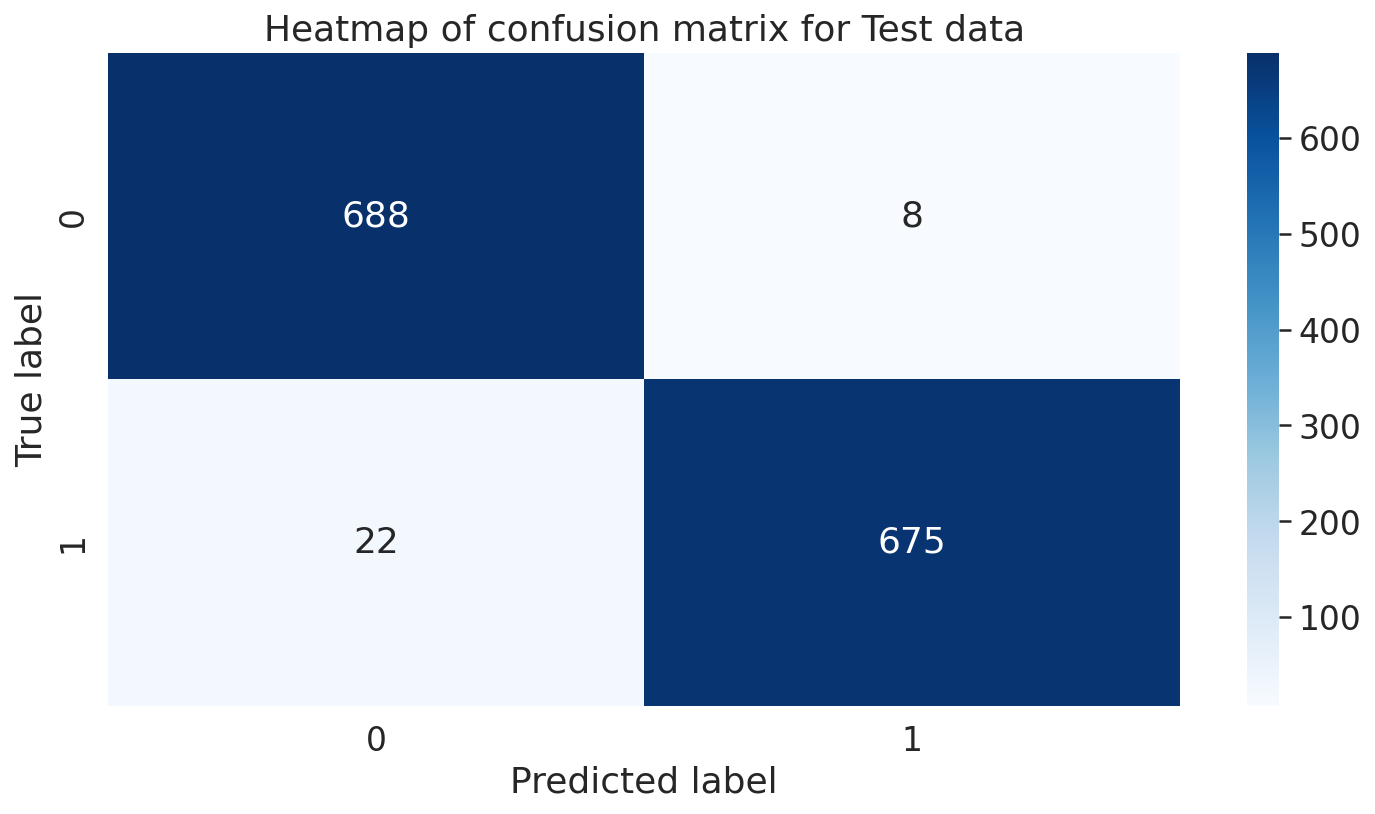

In [64]:
def evaluate(y_test, predictions):
    cf_matrix = confusion_matrix(true_labels, preds.argmax(1))
    sns.heatmap(cf_matrix, annot = True, fmt = 'd',cmap="Blues")
    plt.title('Heatmap of confusion matrix for Test data')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
evaluate(true_labels, preds.argmax(1))

print("Precision Score of the model:", precision_score(true_labels, preds.argmax(1))*100)
print("Recall Score of the model:", recall_score(true_labels, preds.argmax(1))*100)
print("Acuracy score of the model:",accuracy_score(true_labels, preds.argmax(1))*100)
print("F1 score of the model:",f1_score(true_labels, preds.argmax(1))*100)

#### **Classification Report**

In [65]:
class_report= classification_report(true_labels, preds.argmax(1))
print(class_report)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       696
           1       0.99      0.97      0.98       697

    accuracy                           0.98      1393
   macro avg       0.98      0.98      0.98      1393
weighted avg       0.98      0.98      0.98      1393



## **Conclusions**:
- Our model seems to **generalize well** because the **accuracy on the test set** is **similar** to the **accuracy on the validation set** (even higher: **97.85 > 96.85%**).
- When **comparing** the **1st** and **2nd epochs**, **validation loss decreases** which **indicates** that **we aren't over-fitting on the training data**.
- The model achieves a **high F1 Score**: **≈ 97.83%**.
- It is possible that **if we didn't remove the stopwords** we would **achieve a slight increase in F1 Score**. However, as we previously explained, **we chose not to include the stopwords** (with the exception of 'not' and 'no') **due to the reason mentioned above**. We **can't have the best of both worlds!**
